In [1128]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import math


In [1129]:
def data_reading(filename):
    train_data = pd.read_csv (filename, delimiter=",")
    test_data = pd.read_csv ("heart_simplified_test.csv", delimiter=",")
    data_numerical = train_data[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']].values
    data_combined = train_data[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Sex', 'ChestPainType']].values
    data_labels = train_data[['HeartDisease']].values

    #data_numerical_test = test_data[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']].values
    #data_labels_test = test_data[['HeartDisease']].values

    print("Number of samples: %i" % data_numerical.shape[0])
    print("Number of numerical features: %i" % data_numerical.shape[1])
    print("Number of combined features: %i" % data_combined.shape[1])

    return data_numerical, data_combined, data_labels


In [1130]:
test_data_numerical, test_data_combined, test_data_labels = data_reading("heart_simplified_test.csv")
train_data_numerical, train_data_combined, train_data_labels = data_reading("heart_simplified_train.csv")
validation_data_numerical, validation_data_combined, validation_data_labels = data_reading("heart_simplified_validation.csv")

Number of samples: 100
Number of numerical features: 4
Number of combined features: 6
Number of samples: 500
Number of numerical features: 4
Number of combined features: 6
Number of samples: 100
Number of numerical features: 4
Number of combined features: 6


In [1131]:
#result = data_reading("heart_simplified_train.csv")
#train_data = result[0]
#print(train_data[0])
#print(train_data[256])
#train_data_target = result[1]
#test_data = result[2]
#test_data_target = result[3] # tp=data_labels_test
#data_reading("heart_simplified_train.csv")

In [1132]:
#train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_data_target, test_size=0.2)

In [1133]:
#print("val_data", val_data)
#print("val_labels", val_labels)

In [1134]:
class NearestNeighborRegressor:
    
    def __init__(self, n_neighbors=3, weights=[1,1], distance_metric = 'euclidian'):
        """ 
       Initializes the model.

        Parameters
        ----------
        n_neighbors : int
            The number of nearest neigbhors (default 1)
        weights : list
            weighting factors for numerical and categorical features
        distance_metric : str
            The distance metric to use for predictions
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.distance_metric = distance_metric

    
    def fit(self, X, t, type):
        """
        Fits the nearest neighbor regression model.
        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        t : Array of labels [n_samples]
        type: list of fetaure_type ('numerical' or 'combined')
     
        """ 
       
        # reshape both arrays to make sure that we deal with 
        # N-dimensional Numpy arrays
        self.X = np.array(X).reshape((len(X), -1))
        self.t = np.array(t).reshape((-1, 1))
        self.features = type
        self.numerical_features = [i for i in range(X.shape[1]) if self.features[i] == "numerical"]
        self.categorrical_features = [i for i in range(X.shape[1]) if self.features[i] != "numerical"]
       

    
    def predict(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]

        Returns
        -------
        predictions : array-like of length n_samples
        """ 
        predictions = []
        for x in X:
            distances = []
            for i, point in enumerate(self.X):
                if self.distance_metric == 'mixedDistance':
                    distance = self.__mixedDistance(x, point, self.weights[0], self.weights[1])
                else:
                    distance = self.__numericalDistance(x, point)
                distances.append((distance, i))
            distances = sorted(distances, key=lambda x: x[0])
            label_indices = [x[1] for x in distances[:self.n_neighbors]]
            labels = [self.t[i] for i in label_indices]
            predictions.append(np.mean(labels))
        return predictions
  

    
    
    #def __numericalDistance(self, p, q):
        """
        Computes the Euclidean distance between two points.
        """
        return np.sqrt(np.sum((p - q) ** 2))
    
    
    
        
    def __numericalDistance(self, p, q):
        """
        Computes the Euclidean distance between 
        two points.
        """
        distance = math.sqrt(np.sum((q - p)**2))
        return distance

    def __mixedDistance(self, x, point, num_weight, cat_weight):
        distance = 0
        for i in self.num_features:
            if isinstance(x[i], (int, float)):
                distance += num_weight * (x[i] - point[i]) ** 2
        for i in self.cat_features:
            if x[i] != point[i]:
                distance += cat_weight
        return distance

    #def __mixedDistance(self, p, q):
        """
        Computes the distance between 
        two points via the pre-defined matrix.
        """
        distance = 0
        for i in range(len(p)):
            for j in range(len(p)):
                distance += self.X[i][j] * ((p[i] - q[j]) ** 2)
        distance = math.sqrt(distance)
        #print(distance)
        return distance

    #def rmse(self, t, tp):
        """ Computes the RMSE for two input arrays 't' and 'tp'.
        """
        MSE = np.mean(np.square(np.subtract(t,tp)))
        rmse = math.sqrt(MSE)

        return rmse
    def rmse(self, t, tp):
        """ Computes the RMSE for two
        input arrays 't' and 'tp'.
        """
        n = len(t)
        error = (t - tp)**2
        rmse = math.sqrt(np.sum(error)/n)
        #rmse = math.sqrt(np.square(np.subtract(t,tp)).mean())
        return rmse
        
    def optimal_k(self, val_data, val_labels, n_neightbours):
        self.val_labels = val_labels
        rmse_values = []
        for k in n_neightbours:
            # get predictions for the validation set using the current value of k
            predictions = self.predict(val_data)
            for p in range(predictions.shape[1]):
            #print("Predictions", predictions.shape[0])
            #print("val_labels", val_labels.shape[0])
                # calculate the RMSE for the current value of k
                rmse = self.rmse(val_labels, predictions[:,p])

                rmse_values.append(rmse)
        print("RMSE values", rmse_values)

        # find the index of the minimum RMSE value
        min_rmse_index = rmse_values.index(min(rmse_values))
        print("Minimal rmse value at index:%d in array" % min_rmse_index)
        # the optimal k is the value at the same index in k_values
        optimal_k = n_neightbours[min_rmse_index]
        return optimal_k
        

    def accuracy(self, t, tp):
        """ Computes the RMSE for two
        input arrays 't' and 'tp'.
        """   
        correct = 0
        for i in range(len(t)):
            if np.round(t[i]) == np.round(tp[i]):
                correct += 1
        accuracy = correct/len(t)
        return accuracy
    
    def accuracy2(self, y_true, y_pred):
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(len(y_true)):
            if y_true[i] == 1 and y_pred[i] == 1:
                tp += 1
            elif y_true[i] == 0 and y_pred[i] == 1:
                fp += 1
            elif y_true[i] == 0 and y_pred[i] == 0:
                tn += 1
            elif y_true[i] == 1 and y_pred[i] == 0:
                fn += 1
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        return accuracy


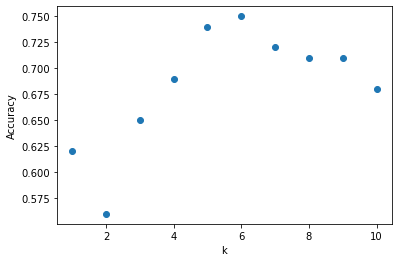

Optimal k: 6
RMSE for optimal k: 5.099020
Accuracy for optimal k: 0.750000


In [1135]:

knn = NearestNeighborRegressor(distance_metric='euclidian')
type = ['numerical'] * 4
knn.fit(train_data_numerical, train_data_labels, type)  # fit the model using the training data

rmses = []
accuracies = []

for k in range(1, 11):
    knn.n_neighbors = k
    predictions = knn.predict(test_data_numerical)
    rmse = knn.rmse(test_data_labels, predictions)
    rmses.append(rmse)
    accuracy = knn.accuracy(test_data_labels, predictions)
    accuracies.append(accuracy)

plt.scatter(range(1, 11), accuracies)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

optimal_k = np.argmax(accuracies) + 1
print("Optimal k: %d" % optimal_k)
print("RMSE for optimal k: %f" % rmses[optimal_k - 1])
print("Accuracy for optimal k: %f" % accuracies[optimal_k - 1])

#validation = predictions.predict(val_data)  # make predictions on the train data



#optimal_k = predictions.optimal_k(val_data, val_labels, n_neightbours)
#print("validation of train set optimal k", optimal_k)

#test = predictions.predict(test_data)
#optimal = predictions.optimal_k(test_data, test_data_target, n_neightbours)
#print("test optimal k", optimal)


#print(train)
#for element in train.tolist():
#    print(element)





#test = predictions.fit(test_data, test_data_target) # fit the model using the test data
#test = predictions.predict(test_data)   # make predictions on the test data
#print(test)

#target_values_predicted = predictions.get_target_values(test_data_target)
#print(target_values_predicted)


#print(test_data_target)
#test_rmse = predictions.rmse(test_data_target, test)
#print("RMSE: %.3f\n" % test_rmse)


#It means that in the predict method, 
# you are trying to subtract self.X 
# (which is the training data that the model was fit on) 
# from the test data (which is passed as the parameter X). 
# However, the shapes of these two arrays are not compatible, 
# which is causing the error. The code is trying to subtract 
# a 500x5 array (self.X) from a 4x1 array (X) which is not possible.

#So instead of using the test data passed as a parameter, 
# the code is using the training data that the model was fit 